In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# whereever there is sea ice, make that value NaN

def remove_seaice_from_storms(storms_ds, sea_ice_ds, variables):
    """
    Remove sea ice from storm datasets by setting values to NaN where sea ice is present.
    
    Parameters:
    storms_ds (xarray.Dataset): Dataset containing storm data.
    sea_ice_ds (xarray.Dataset): Dataset containing sea ice concentration data.
    variables (list): List of variable names in the storms dataset to be modified.
    
    Returns:
    None: The function modifies the storms_ds in place.
    """
    storms_seaice_no_ice = sea_ice_ds.siconc.where(sea_ice_ds.siconc == 0, np.nan)

    storms_seaice_no_ice = storms_seaice_no_ice.where(storms_seaice_no_ice != 0, 1)

    for v in variables:

        storms_ds[v] = storms_ds[v].where(storms_seaice_no_ice == 1, np.nan)

    return storms_ds

In [3]:
# load the sea ice cover dataset - only needs to be loaded once
# this is the dataset that contains sea ice concentration
sea_ice_ds = xr.open_dataset('/home/mduplessis/data/era5/storms/combined_storms_sea_ice_cover.nc').load()

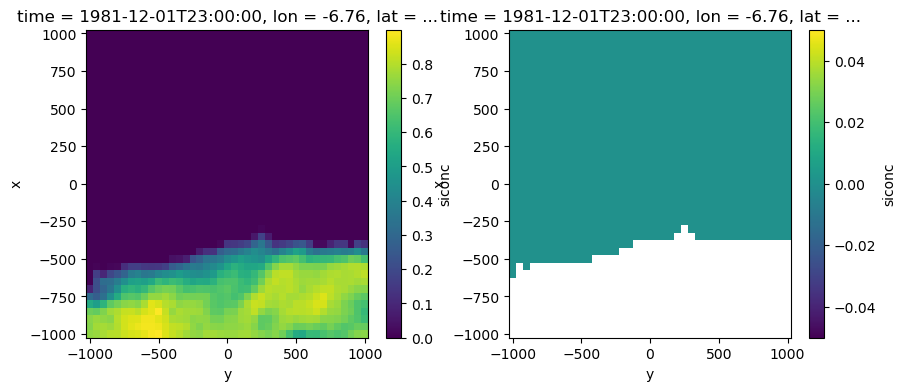

In [6]:
# load the storm dataset
variable = 'sea_ice_cover'  # Change this to the desired variable

variables = ['siconc']

storms_ds = xr.open_dataset(f'/home/mduplessis/data/era5/storms/combined_storms_{variable}.nc').load()

# check the size comparison between the variable dataset and the sea ice dataset 

if storms_ds.time.size != sea_ice_ds.time.size:
    print(f"Warning: The time dimension sizes for the chosen {variable} dataset and sea ice dataset do not match: {storms_ds.time.size} vs {sea_ice_ds.time.size}")
    
    # if the size of the storms dataset does not match the sea ice, then resize it to match
    storms_ds = storms_ds.isel(time=np.arange(sea_ice_ds.time.size))

storms_ds = remove_seaice_from_storms(storms_ds, sea_ice_ds, variables)

# test plot to see that it worked

fig,ax=plt.subplots(1,2,figsize=(10,4))

sea_ice_ds['siconc'].isel(time=200).plot(ax=ax[0])
storms_ds[variables[0]].isel(time=200).plot(ax=ax[1])

In [8]:
storms_ds.to_netcdf(f'/home/mduplessis/data/era5/storms/combined_storms_{variable}_no_ice.nc')